<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/21_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_(%D0%BB%D0%B8%D1%82%D0%B5%D1%80%D0%B0%D1%82%D1%83%D1%80%D0%B0_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Рекуррентные нейронные сети](https://colab.research.google.com/drive/1Mm5yFeJXZT9YcwlQMGx_T5JcEVgV8ZWy)
2. [Одномерные сверточные нейронные сети](https://colab.research.google.com/drive/1SCmcJdfsaxpJiQz_SOMH6gixV-43zPIB)
3. [Сравнение архитектур рекуррентных и одномерных сверточных сетей](https://colab.research.google.com/drive/15-SEqMwU3ALZmiEtlJFZllc38VTGHkGu)
4. Домашняя работа

Когда вы еще учились в школе, то вас часто мучали написанием сочинений. Может быть даже кто-нибудь из вас увлекался написанием стихотворений, романов или прозы. А значит, в вас живет дух великого русского писателя. А вот интересно какого? В данной домашней работе мы это и выясним!

Чтобы узнать на какого писателя вы похожи необходимо выполнить следующее задание:

1. Скачать датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip). Каждый текст необходимо разбить на обучающую, проверочную и тестовую выборки, для этого модифицируйте функцию `seq_vectorize`, чтобы она возвращала все 3 выборки.
2. Используя материалы из ноутбука практического занятия [сравнение архитектур рекуррентных и одномерных сверточных сетей](https://colab.research.google.com/drive/15-SEqMwU3ALZmiEtlJFZllc38VTGHkGu), выберите лучший вариант нейронки и адаптируйте ее структуру.
3. Подгрузите веса Наташи как в уроке [20.3](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP) для слоя эмбендинга.
4. Заморозьте слой эмбединга.
5. Обучите модель на любом числе писателей (не менее 4-х) с балансировкой. Используйте обучающую выборку для обучения, а проверочную - в качестве валидационных данных (`validation_data`).
6. Постройте матрицу ошибок на тестовых образцах! В примерах мы строили на проверочных. Добейтесь средней точности более 70% на тестовых образцах. Получите 3 балла.
7. Если сможете добиться точности более 90% получите +1 балл.
8. Подготовьте свой текст и предложите нейронке предсказать на кого из русских писателей похож ваш текст. Вам необходимо построить круговую диаграмму с вероятностями предсказания моделью автора сочинения (по тестовой выборке). Если текст будет вашего авторства, то вы получите +1 балл. Если у вас плохо с фантазией, то возьмите небольшой фрагмент вашего любимого произведения любого автора, не представленного в датасете.

In [53]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec
!pip install --upgrade keras

--2024-10-13 12:00:49--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.2’

navec_hudlit_v1_12B 100%[===================>]  50.56M  19.0MB/s    in 2.7s    

2024-10-13 12:00:53 (19.0 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.2’ saved [53012480/53012480]



In [88]:
from keras.models import Sequential
from keras.utils import get_file, to_categorical
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, SimpleRNN
from keras.layers import GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import glob
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

import keras
data_path = keras.utils.get_file("russian_literature.zip", "https://storage.yandexcloud.net/academy.ai/russian_literature.zip")

!unzip -qo "{data_path}" -d ./dataset
CLASS_LIST=['Turgenev', 'Gogol', 'Chekhov', 'Herzen', 'Pushkin', 'Gorky', 'Bryusov']

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


In [89]:
all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
            # Загрузка содержимого файла в строку
            text = f.read()

        all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

In [90]:
embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 15000      # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)

tokenizer.fit_on_texts(all_texts.values())
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [91]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())
seq_train_balance = [seq_train[cls][:240_000] for cls in range(len(CLASS_LIST))]

total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 2076371 слов


In [92]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Turgenev - 240000 слов, доля в общей базе: 11.56%
Gogol - 240000 слов, доля в общей базе: 11.56%
Chekhov - 240000 слов, доля в общей базе: 11.56%
Herzen - 153569 слов, доля в общей базе: 7.40%
Pushkin - 170369 слов, доля в общей базе: 8.21%
Gorky - 240000 слов, доля в общей базе: 11.56%
Bryusov - 240000 слов, доля в общей базе: 11.56%
Среднее значение слов:  217705.0
Медианное значение слов:  240000.0


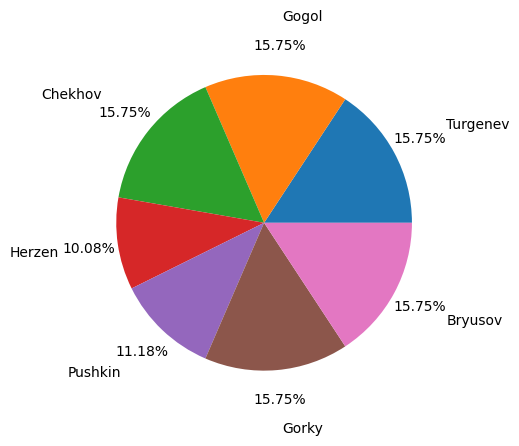

In [93]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%')                     # формат для % (2 знака после запятой)

plt.show()

In [94]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую выборку
    val_split,
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step):        # Шаг скользящего окна

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test, x_val, y_val =  [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)


        gate_split_val = int(len(seq_list[cls])*val_split)
        gate_split_test = int(len(seq_list[cls])*(val_split+test_split))

        vectors_val = seq_split(seq_list[cls][:gate_split_val], win_size, step)
        vectors_test = seq_split(seq_list[cls][gate_split_val:gate_split_test], win_size, step)
        vectors_train = seq_split(seq_list[cls][gate_split_test:], win_size, step)

        x_train += vectors_train
        x_test += vectors_test
        x_val += vectors_val

        y_train += [to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [to_categorical(cls, len(class_list))] * len(vectors_test)
        y_val += [to_categorical(cls, len(class_list))] * len(vectors_val)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), np.array(x_val), np.array(y_val)

In [95]:
x_train, y_train, x_test, y_test, x_val, y_val = seq_vectorize(seq_train_balance, 0.05, 0.05, CLASS_LIST, WIN_SIZE, WIN_STEP)

In [96]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')
print()
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')
print()
print(f'Форма входных данных для валидационной выборки: {x_val.shape}')
print(f'Форма выходных данных (меток) для валидационной выборки: {y_val.shape}')

Форма входных данных для обучающей выборки: (13652, 1000)
Форма выходных данных (меток) для обучающей выборки: (13652, 7)

Форма входных данных для тестовой выборки: (698, 1000)
Форма выходных данных (меток) для тестовой выборки: (698, 7)

Форма входных данных для валидационной выборки: (698, 1000)
Форма выходных данных (меток) для валидационной выборки: (698, 7)


In [97]:
def show_plot(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели: '+title)
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [98]:
def loadEmbedding(model):
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    # model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

In [99]:
model_MIX = Sequential()
model_MIX.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(16, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(16, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(32, return_sequences=True, reset_after=True))
model_MIX.add(GRU(32, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(200, activation='relu'))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [100]:
model_MIX = loadEmbedding(model_MIX)

In [101]:
model_MIX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mix = model_MIX.fit(x_train, y_train, epochs=75, batch_size=180, validation_data=(x_test, y_test))

Epoch 1/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 235ms/step - accuracy: 0.1422 - loss: 2.4025 - val_accuracy: 0.1590 - val_loss: 1.9287
Epoch 2/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.1535 - loss: 2.1546 - val_accuracy: 0.1590 - val_loss: 1.9287
Epoch 3/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.1702 - loss: 2.0606 - val_accuracy: 0.1705 - val_loss: 1.9253
Epoch 4/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.1981 - loss: 1.9798 - val_accuracy: 0.1662 - val_loss: 2.1860
Epoch 5/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.2431 - loss: 1.8839 - val_accuracy: 0.1633 - val_loss: 2.0799
Epoch 6/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.2899 - loss: 1.7740 - val_accuracy: 0.1590 - val_loss: 3.0254
Epoch 7/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.2801 - loss: 1.8198 - val_accuracy: 0.3095 - val_loss: 1.8455
Epoch 8/75
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.3587 - loss: 1.6686 - val_accu

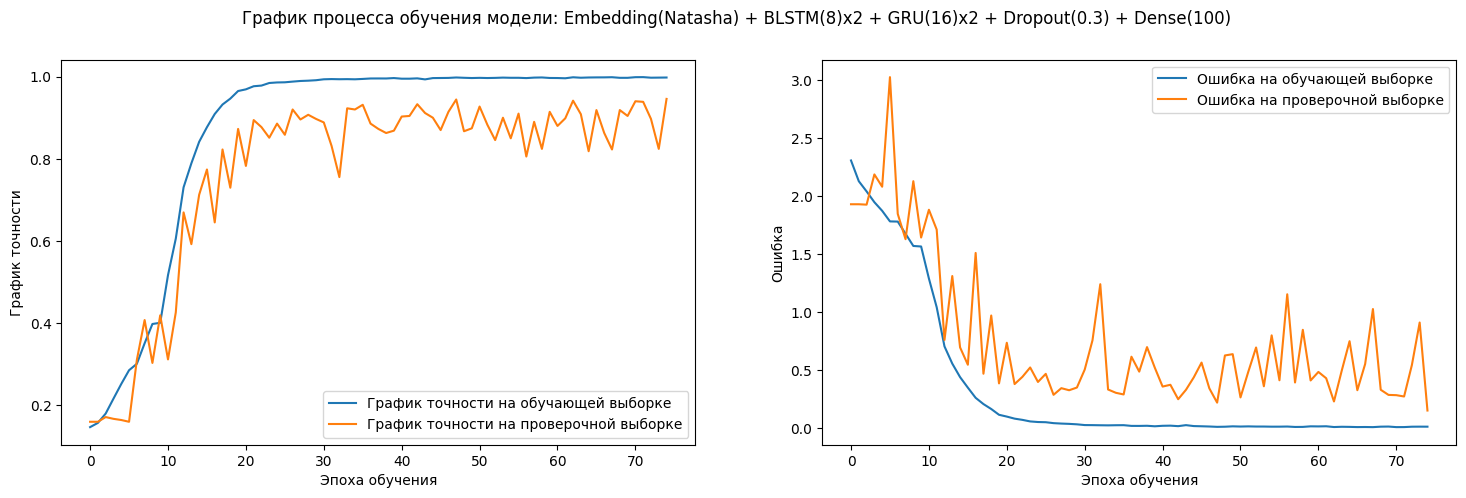

In [102]:
show_plot(history_mix, 'Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100)')

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


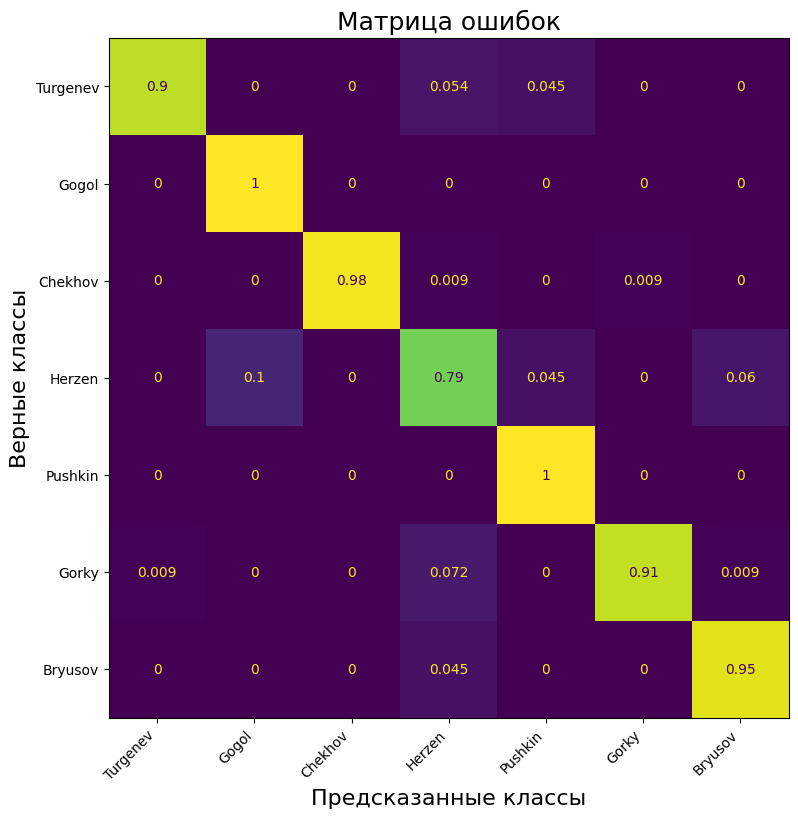


Средняя точность распознавания:  93%


In [103]:
y_pred_mix = model_MIX.predict(x_val)
show_confusion_matrix(y_val, y_pred_mix, CLASS_LIST)